<a href="https://colab.research.google.com/github/reddyaravind/Deep-Learning-Project/blob/master/Copy_of_prophet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                                    Case Study
<hr style="border: 4px solid black;" />

![title](theme.png)

<h2>Problem Statement</h2>
<hr style="border: 1px solid black;" />


This is kaggle competition problem .in this problem we have given historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.For more information click on this below link <br>
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/evaluation

<h2>Problem Evaluation</h2>
<hr style="border: 1px solid black;" />


This Problem is evaluated on the weighted mean absolute error (WMAE):

                       WMAE=1∑wi∑i=1nwi|yi−y^i|
where

n is the number of rows<br>
y^i is the predicted sales<br>
yi is the actual sales<br>
wi are weights. w = 5 if the week is a holiday week, 1 otherwise

![title](sub.png)

<h1>Submission score criteria</h1>
<hr style="border: 1px solid black;" />

![title](Submission1.png)

There are total 688 submission of this problem and according to criteria of acceptence of case study is our submission score should be under top 10%

![title](Submission.png)
last 10% submisson score is 2850,so our score should be under 2850

<h3>importing all the libraries</h3>
<hr style="border: 1px solid black;" />

In [1]:
!pip install pendulum

     |████████████████████████████████| 163kB 8.9MB/s 
     |████████████████████████████████| 491kB 16.9MB/s 


In [2]:
#importing all the libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb 
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import seaborn as sns
# The current ver  sion of seaborn generates a bunch of warnings that we'll ignore
import warnings 
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
import os
import time
from datetime import datetime



import pendulum


#from xgboost import XGBRegressor
import pickle
from pandas import to_datetime
import lightgbm 
 
#from fbprophet import Prophet

In [3]:
#reading a csv file
feat=pd.read_csv('features.csv')
store=pd.read_csv('stores.csv')
sales_train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sales_test = pd.read_csv('test.csv')


<h1>Feature engineering

In [4]:
#here we merging the train ,features,store dataframe together
train_merge=sales_train.merge(store,how='left')
train=train_merge.merge(feat,how='left')

In [5]:
#here we merging the test,features,store dataframe together
test_merge=test.merge(store,how='left')  
test=test_merge.merge(feat,how='left')

In [6]:
# Concatenating train & test
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'
merged_datframe = pd.concat([train,test], sort=False)
print('Combined merged_df shape:{}'.format(merged_datframe.shape))

Combined merged_df shape:(493672, 17)


In [7]:
merged_datframe.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'train_or_test'],
      dtype='object')

In [8]:
# here we are Sorting the dataframe by store then Dept then date
merged_datframe = merged_datframe.sort_values(by=['Store','Dept','Date'], axis=0).reset_index().drop(columns='index')

In [9]:
# here we use One-hot-encode for  "Type" categorical variables 
merged_datframe = pd.get_dummies(merged_datframe, columns=['Type'])


In [10]:
# here we use Label-encoder for  "IsHoliday" categorical variables 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_datframe['IsHoliday'] = le.fit_transform(merged_datframe['IsHoliday'])

In [11]:
# here we are Create new features ,their names are  - "IsSuperbowl", "IsLaborday", "IsThanksgiving", "IsChristmas" .in this feature we create four new columns in which we creating  some 
#special holidays like laborday,superbowl etc .if these dataes are available in our data then it will be 1 otherwise as 0

def Superbowl(x):
  if (x == '2010-02-12') | (x == '2011-02-11') | (x == '2012-02-10') | (x == '2013-02-08'):
    return 1
  else:
    return 0

def Laborday(x):
  if (x == '2010-09-10') | (x == '2011-09-09') | (x == '2012-09-07') | (x == '2013-09-06'):
    return 1
  else:
    return 0

def Thanksgiving(x):
  if (x == '2010-11-26') | (x == '2011-11-25') | (x == '2012-11-23') | (x == '2013-11-29'):
    return 1
  else:
    return 0

def Christmas(x):
  if (x == '2010-12-31') | (x == '2011-12-30') | (x == '2012-12-28') | (x == '2013-12-27'):
    return 1
  else:
    return 0

merged_datframe['IsSuperbowl'] = merged_datframe['Date'].apply(lambda x: Superbowl(x)) # adding the Issuperbowl feature
merged_datframe['IsLaborday'] = merged_datframe['Date'].apply(lambda x: Laborday(x))
merged_datframe['IsThanksgiving'] = merged_datframe['Date'].apply(lambda x: Thanksgiving(x))
merged_datframe['IsChristmas'] = merged_datframe['Date'].apply(lambda x: Christmas(x))

In [12]:
# Extract features from "Date" feature
merged_datframe['WeekofMonth'] = merged_datframe['Date'].apply(lambda x: pendulum.parse(x).week_of_month) # here we are fetching week of month for date
merged_datframe['Date'] = pd.to_datetime(merged_datframe['Date']) #Here we are converting the date column into datetime feature
merged_datframe['Year'] = merged_datframe['Date'].dt.year         #Here we are extracting the date from  date column
merged_datframe['Month'] = merged_datframe['Date'].dt.month       #Here we are extracting the month from  date column
merged_datframe['Week'] = merged_datframe['Date'].dt.week         #Here we are extracting week from  date column
merged_datframe['Day'] = merged_datframe['Date'].dt.day           #Here we are extracting day from  date column

In [13]:
# Features constructed from previous sales values
#https://www.kaggle.com/abhilashawasthi/feature-engineering-lgb-model

#this function will return the value of aggreagrate function that we pass like(mean ,minimum,maximum ,median of weekly sale)
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:'Monthly_Sales_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

# this function will return last 52 day monthly sale value for every rows
def last_52_days(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
    
        df['_'.join([target_col, 'lag', str(i)])] = gpby[target_col].shift(i).values 
    return df

##this function will return exponential mean of  last 52 day monthly sale value for every rows
def exponential_mean_last_52_days(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = gpby[target_col].apply(lambda x: x.shift(s).ewm(alpha=0.95).mean())
    return df

In [14]:
# creating sales lag features 
import numpy as np
merged_new_datframe = last_52_days(merged_datframe, gpby_cols=['Store','Dept'], 
                                       target_col='Weekly_Sales', lags=[52])

# creating ewm features 
merged_new_datframe= exponential_mean_last_52_days(merged_new_datframe, gpby_cols=['Store','Dept'], 
                                       target_col='Weekly_Sales', alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5],
                                       shift=[52])

# creating sales monthwise aggregated values
df= create_sales_agg_monthwise_features(merged_new_datframe.loc[~(merged_new_datframe.train_or_test=='test'), :], gpby_cols=['Store','Dept', 'Month'], 
                                               target_col='Weekly_Sales', 
                                             agg_funcs={'mean':np.mean, 
                                              'median':np.median, 'max':np.max, 
                                              'min':np.min, 'std':np.std})
# # Joining agg_df with merged_df_new
merged_new_datframe = merged_new_datframe.merge(df, on=['Store','Dept', 'Month'], how='left')

In [15]:
#here we are dropping the unnecessary columns
merged_datframe = merged_datframe.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)


In [16]:
#now we are seperating the train and test data
# Final train and test datasets
train = merged_new_datframe.loc[merged_new_datframe.train_or_test=='train', :]
test = merged_new_datframe.loc[merged_new_datframe.train_or_test=='test', :]
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))

Train shape:(378608, 40), Test shape:(115064, 40)


<h1>Visualisation

<AxesSubplot:xlabel='Weekly_Sales'>

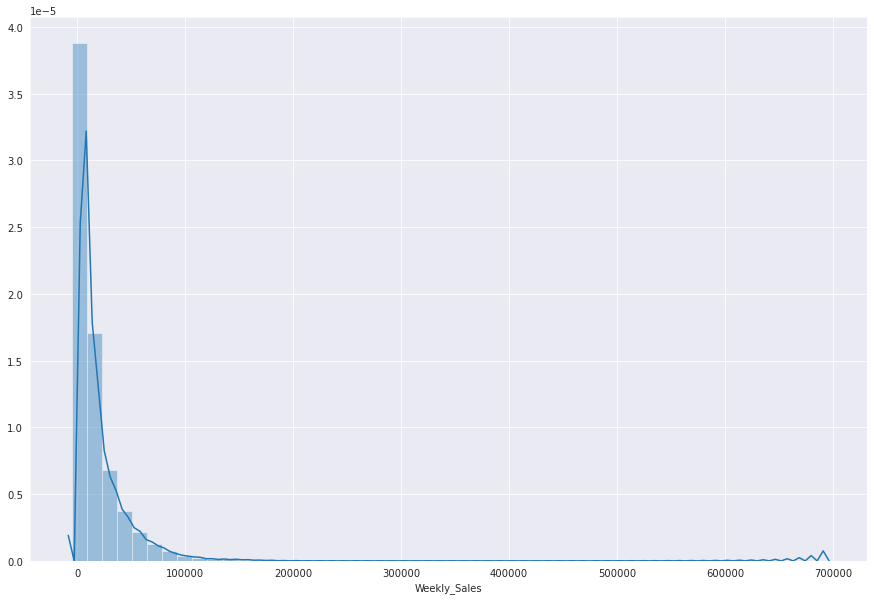

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,10))
sns.distplot(train['Weekly_Sales'])

Here we can observe that weekely sales plot is look like right side skew distribution and most of the sales lies between 0 to 10 thosand

[Text(0.5, 1.0, 'Year vs Weekly_sales ')]

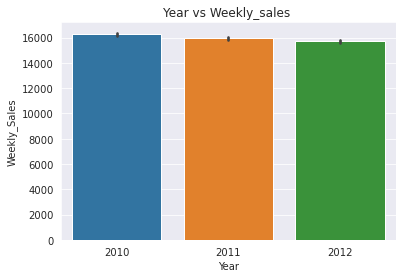

In [ ]:
#year wise sales
import seaborn as sns

sns.barplot(x='Year', y='Weekly_Sales', data=train).set(title='Year vs Weekly_sales ')

Here we can observe that all of the three years, 2010 year have maximum sales

[Text(0.5, 1.0, 'Store vs Weekly_sales_min ')]

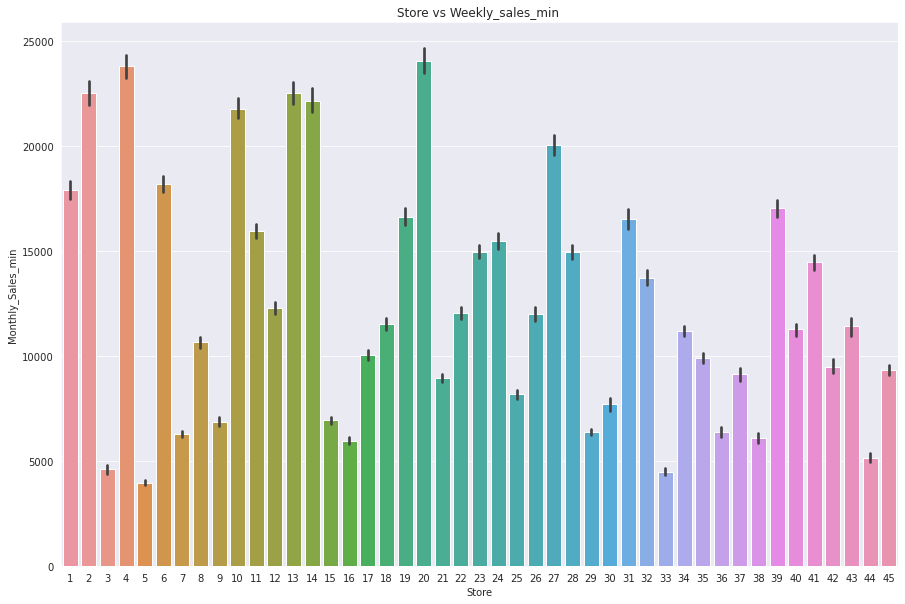

In [ ]:
#Weekly sales year wise
plt.figure(figsize=(15,10))
sns.barplot(x='Store', y='Monthly_Sales_min' ,data=train).set(title='Store vs Weekly_sales_min ')

Here we can observe that only (3,5) are the store numbers whose sales is minimum and under 5000

[Text(0.5, 1.0, ' stores vs monthly_sales_max ')]

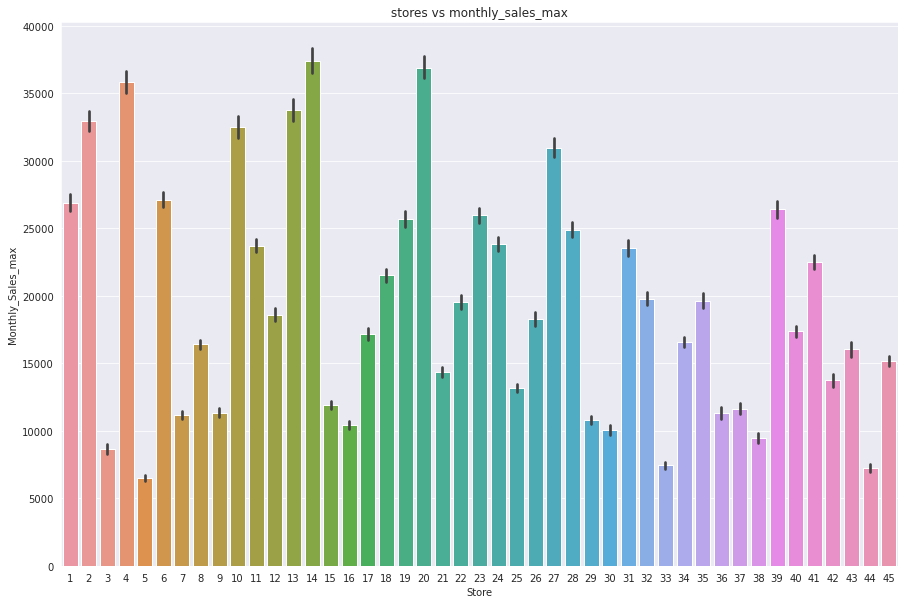

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='Store', y='Monthly_Sales_max' ,data=train).set(title=' stores vs monthly_sales_max ')

Here we can observe that only (4,14,20) are the store numbers whose sales is maximum and greater then 35000

<AxesSubplot:xlabel='Store', ylabel='Monthly_Sales_mean'>

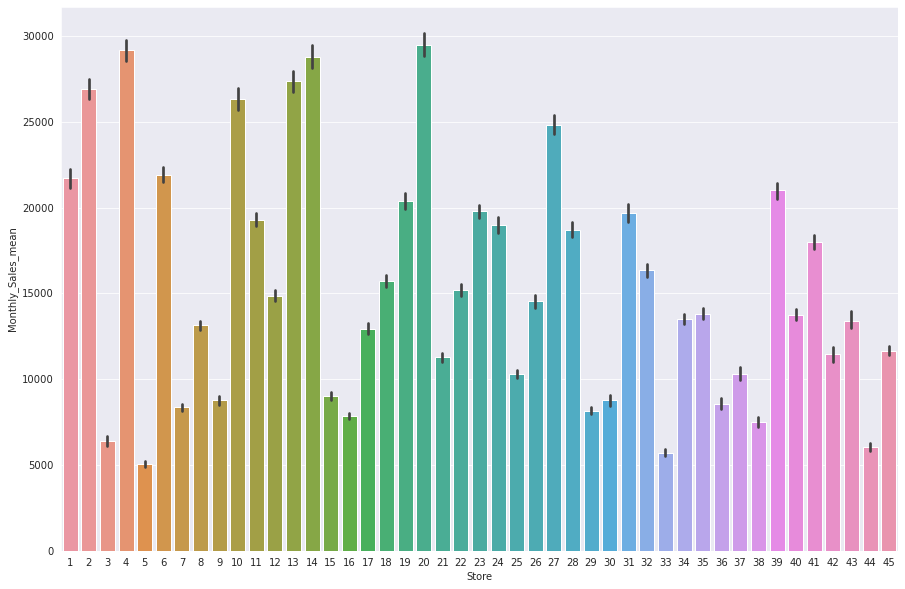

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='Store', y='Monthly_Sales_mean' ,data=train)

[Text(0.5, 1.0, ' stores vs Weekly_sales')]

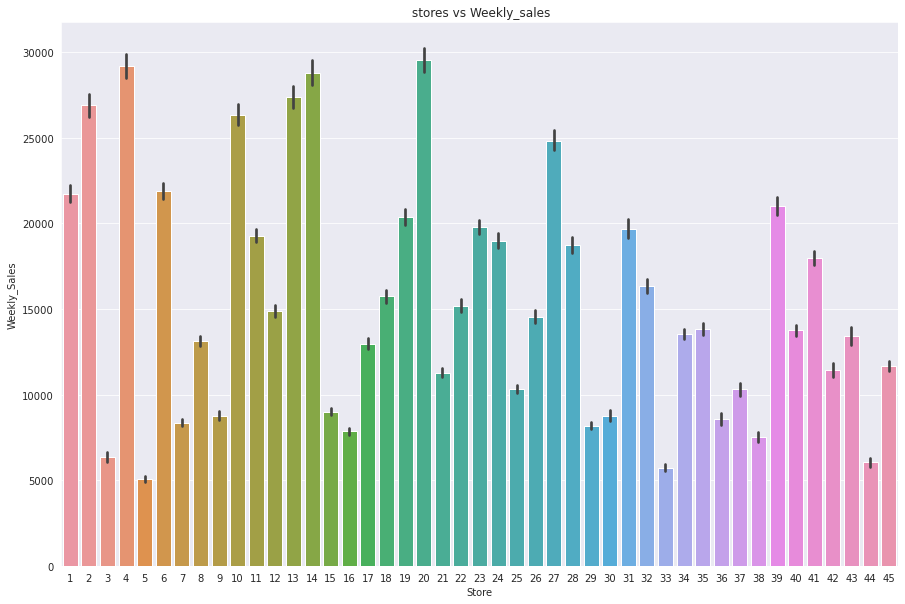

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='Store', y='Weekly_Sales' ,data=train).set(title=' stores vs Weekly_sales')

Here we can observe that most of the store have sales under 20 thousand

[Text(0.5, 1.0, 'Dept vs Weekly_sales')]

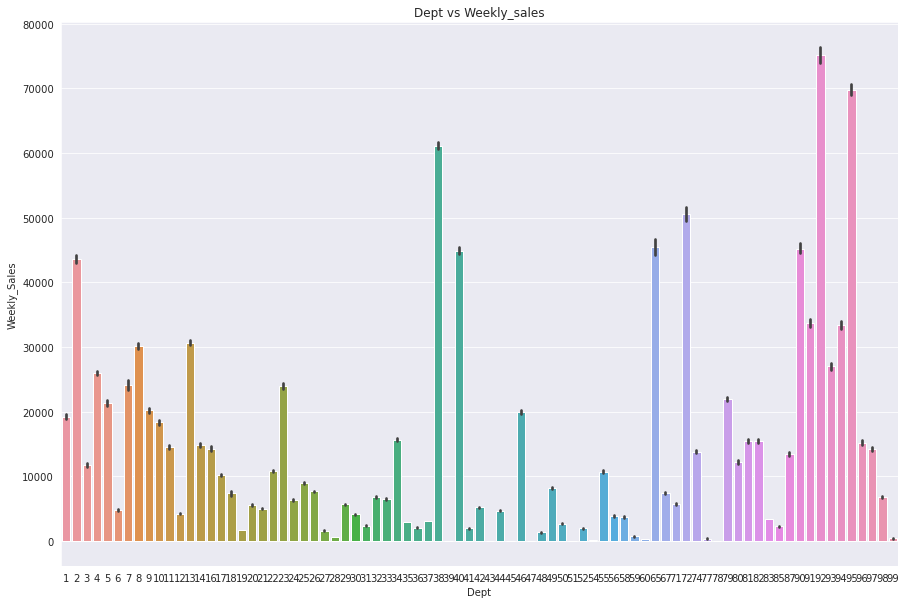

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='Dept', y='Weekly_Sales' ,data=train).set(title='Dept vs Weekly_sales')

Here we can observe that some  of the Department have sales less then 1000

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

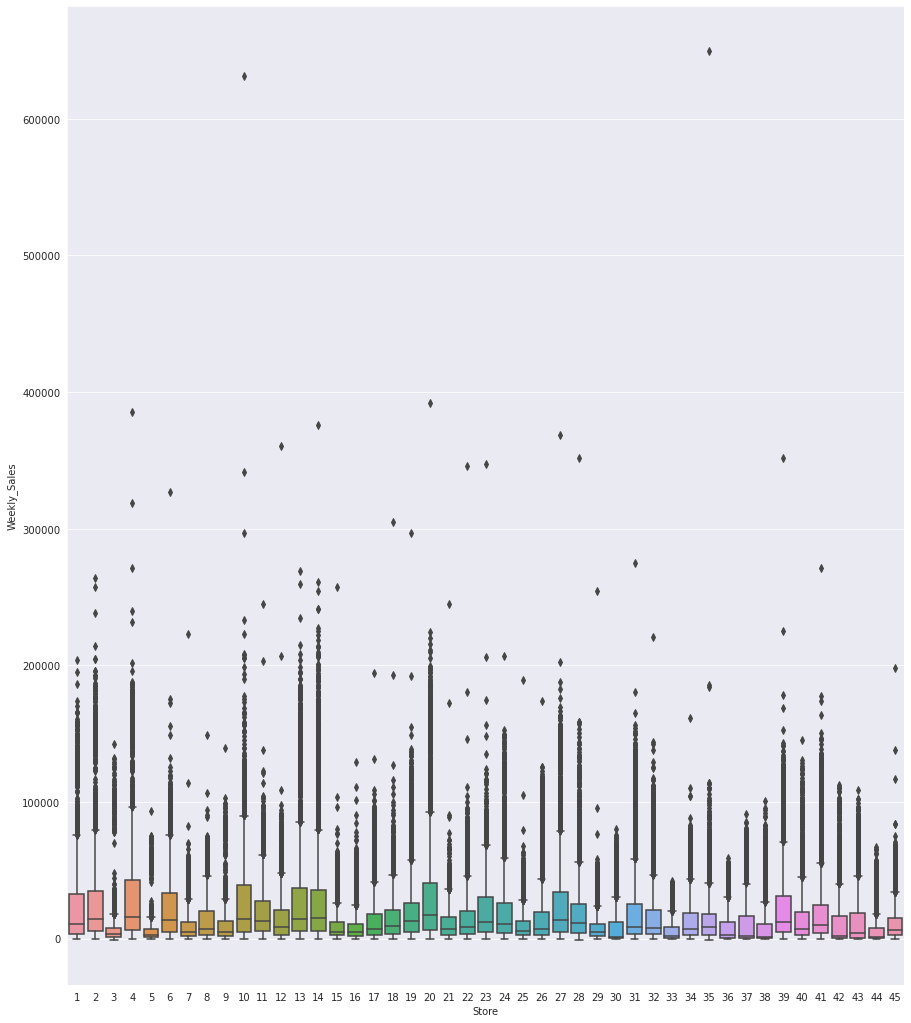

In [ ]:
#box  plot of weekely sales vs stores
plt.figure(figsize=(15,18))
sns.boxplot(x="Store", y="Weekly_Sales", data=train)

Here we can observe that 10 and 35 store number have some outliers and most of the store have 75% sales under 3000

<AxesSubplot:xlabel='Store', ylabel='Monthly_Sales_max'>

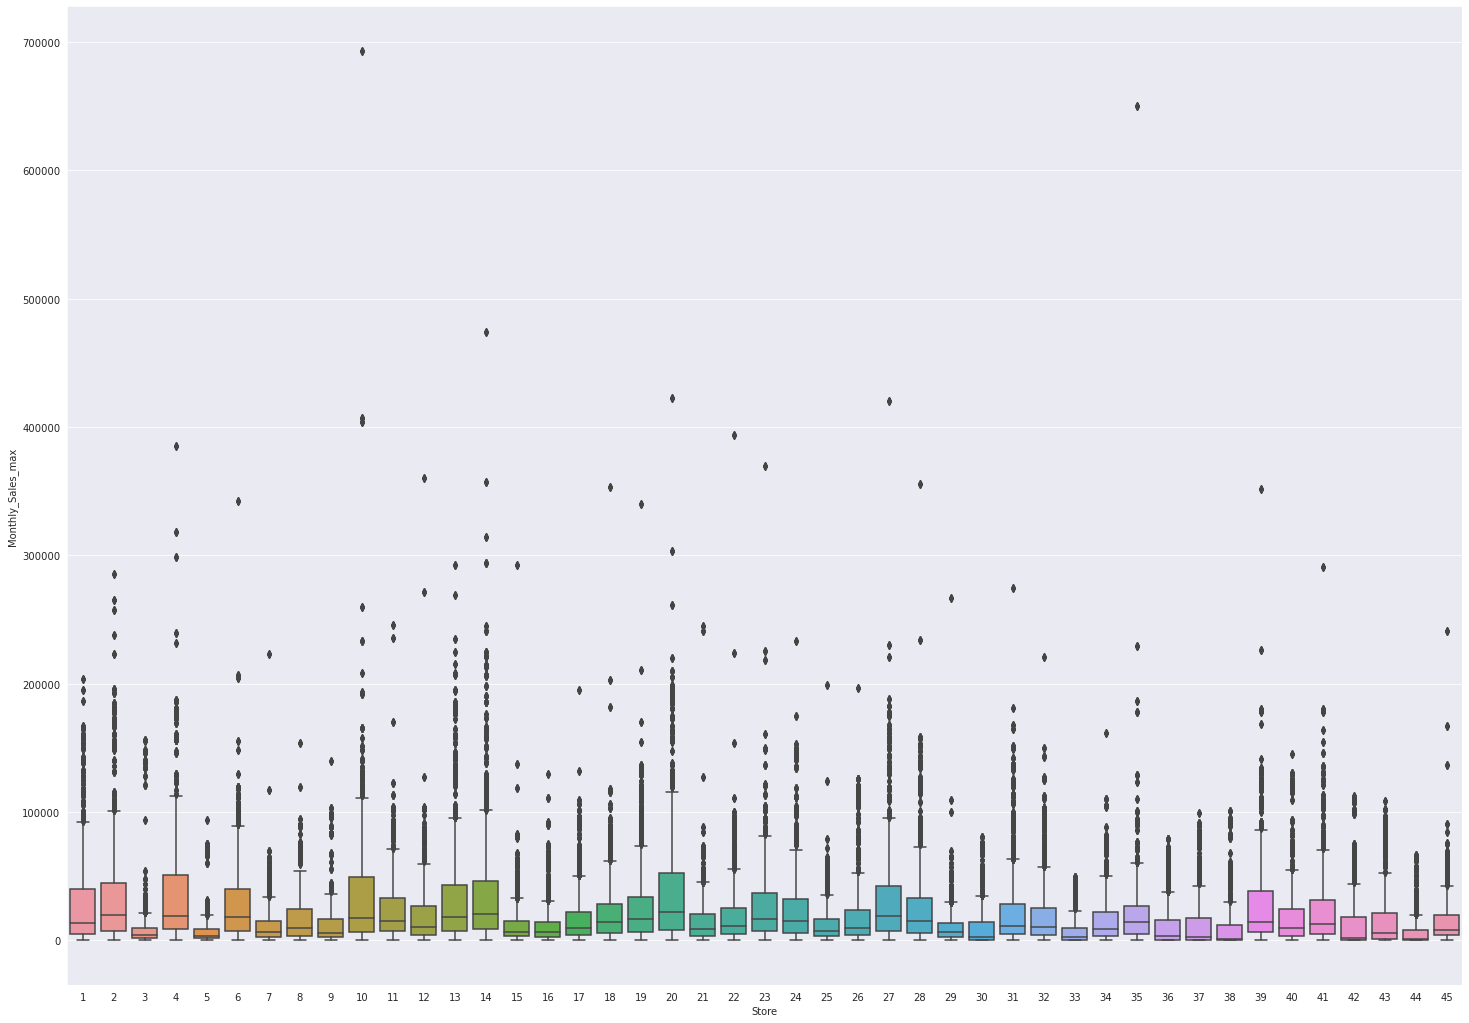

In [ ]:
#box plot of minimum weekely sale vs store
plt.figure(figsize=(25,18))
sns.boxplot(x="Store", y="Monthly_Sales_max", data=train)

here we can we observe that 4,10,20,27 store number have 75 % have highest weekly sale

<AxesSubplot:xlabel='Dept', ylabel='Monthly_Sales_min'>

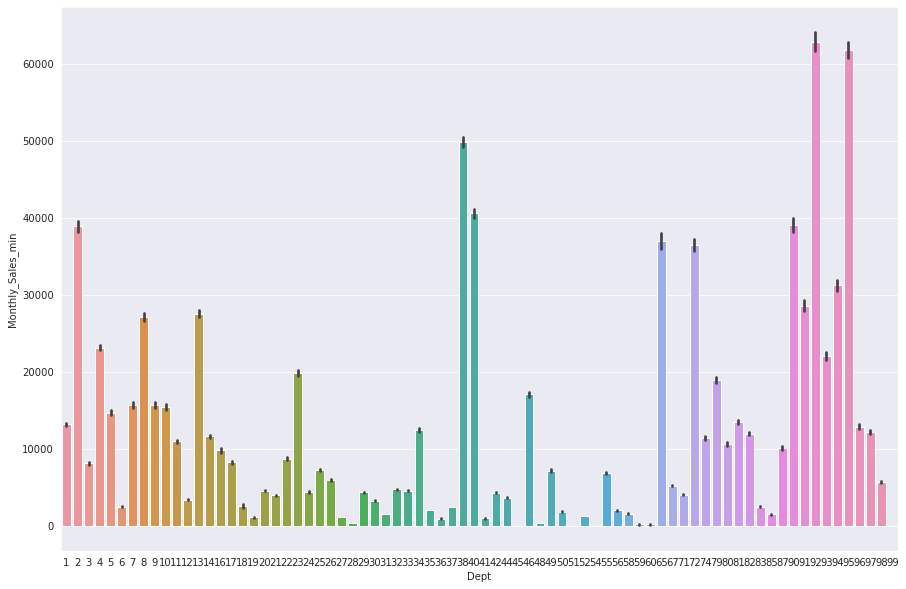

In [ ]:
#Bar plot of minumm weekely sale vs department
plt.figure(figsize=(15,10))
sns.barplot(x='Dept', y='Monthly_Sales_min' ,data=train)

Here we can observe that there are some departement whose sales is under 1000

<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

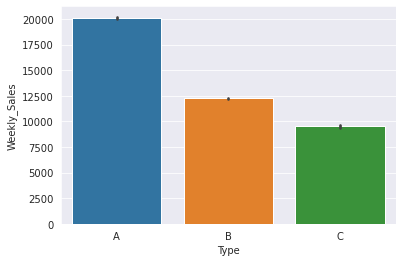

In [ ]:
#type wise weekely_sale
sns.barplot(x='Type', y='Weekly_Sales' ,data=merged_datframe)

Here we can observe that type A have maximum sales whereas type c have lowest sales

[Text(0.5, 1.0, ' stores vs Minimum_Month_sales')]

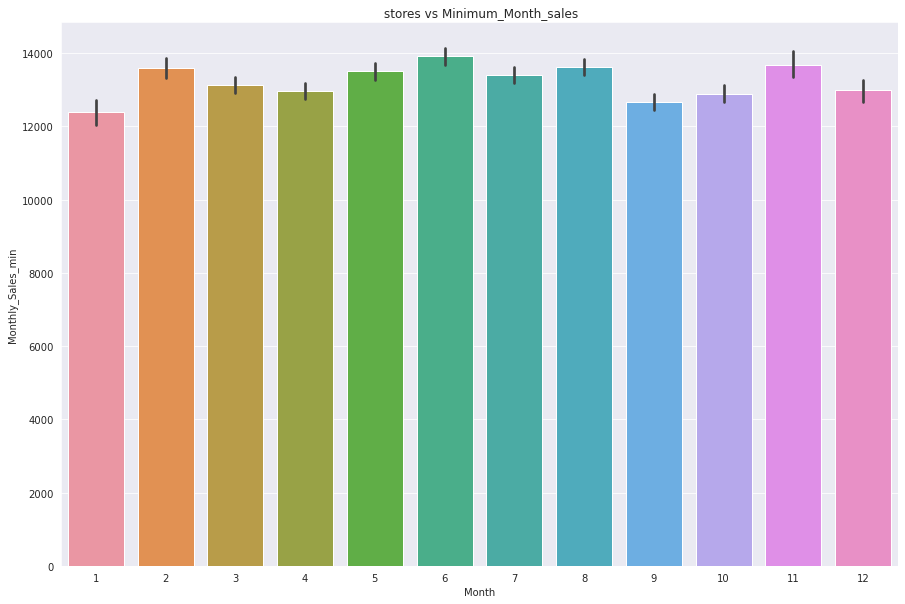

In [ ]:
#minumm sales month wise
plt.figure(figsize=(15,10))
sns.barplot(x='Month', y='Monthly_Sales_min' ,data=train).set(title=' stores vs Minimum_Month_sales')

#Here we van observe that Month 1 have lowest sale

[Text(0.5, 1.0, ' stores vs Monthly_sales_max')]

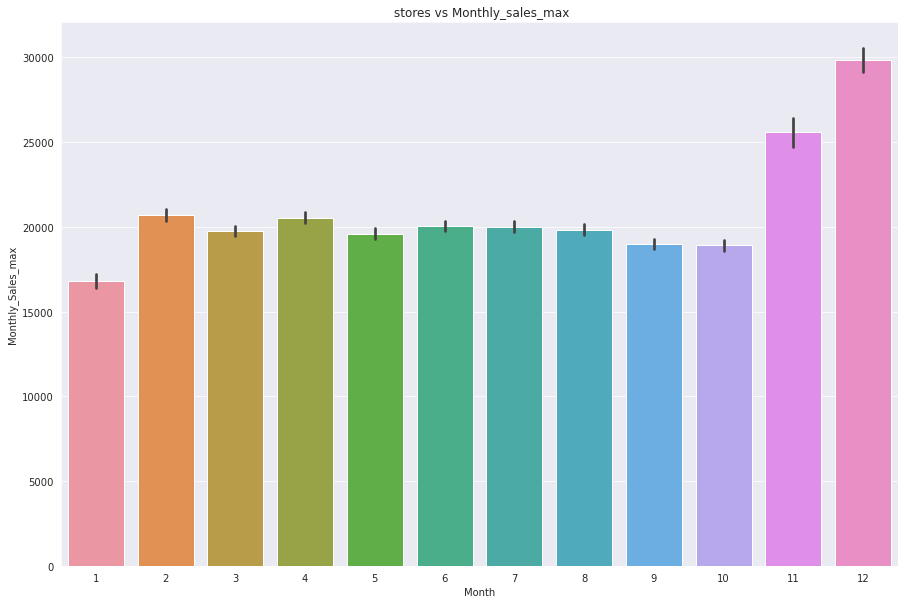

In [ ]:
#bar plot of max monthly sale vs stores
plt.figure(figsize=(15,10))
sns.barplot(x='Month', y='Monthly_Sales_max' ,data=train).set(title=' stores vs Monthly_sales_max')

Here we can observe that last 2 Months(11,12) have highest sale

[Text(0.5, 1.0, ' week vs Monthly_sales_max')]

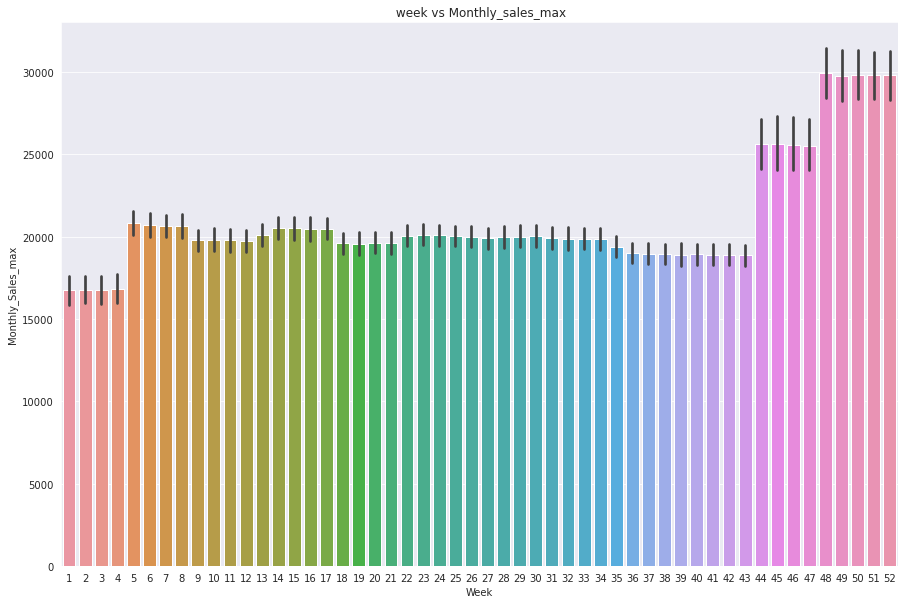

In [ ]:
#bar plot of week wise minimum sale 
plt.figure(figsize=(15,10))
sns.barplot(x='Week', y='Monthly_Sales_max' ,data=train).set(title=' week vs Monthly_sales_max')

Here we can observe that from 44 to 52 week have highest maximum sale and first 4 week have minimum sale

[Text(0.5, 1.0, ' stores vs minimum_monthly_sales')]

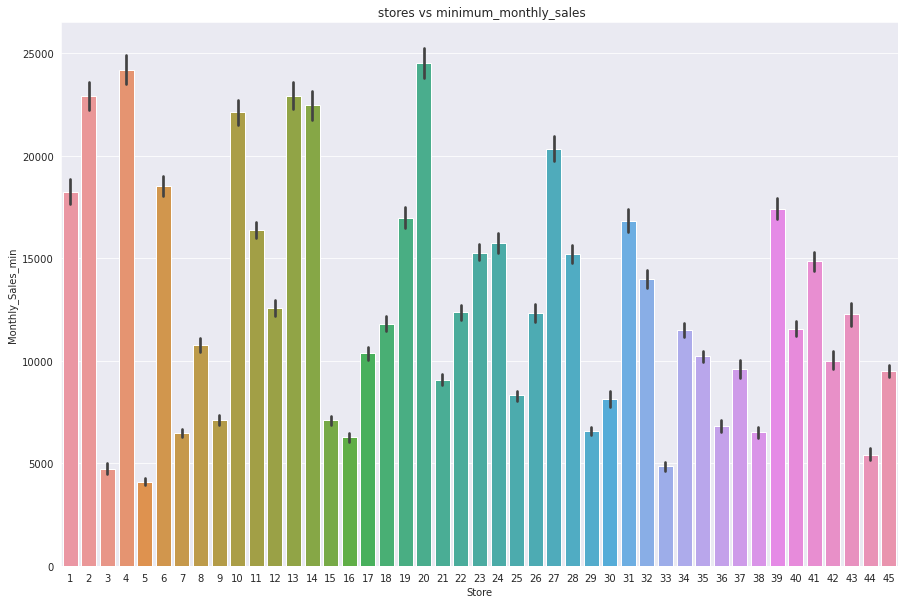

In [ ]:
plt.figure(figsize=(15,10))
sns.barplot(x='Store', y='Monthly_Sales_min' ,data=train).set(title=' stores vs minimum_monthly_sales')

here we can obserev that store number 5 have lowest sale whereas store number 2,4,19 have hishest sale

In [ ]:
#dropping the date and train_test columns from the train dataset
train = train.drop(['Date', 'train_or_test'], axis=1).dropna() 

#dropping the date and train_test and weekly_sales columns from the train dataset and filling the empty rows with 0

test = test.drop(['Date', 'train_or_test', 'Weekly_Sales'], axis=1) .fillna(0)

In [ ]:
#let store the cleaned train and test dataset in to csv file in directory
train.to_csv('final_train.csv',index=False)
test.to_csv('final_test.csv',index=False)

In [ ]:
train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,CPI,Unemployment,Type_A,...,Weekly_Sales_lag_52_ewm_0.9,Weekly_Sales_lag_52_ewm_0.8,Weekly_Sales_lag_52_ewm_0.7,Weekly_Sales_lag_52_ewm_0.6,Weekly_Sales_lag_52_ewm_0.5,Monthly_Sales_mean,Monthly_Sales_median,Monthly_Sales_max,Monthly_Sales_min,Monthly_Sales_std
52,1,1,21665.76,0,151315,42.27,2.989,212.566881,7.742,1,...,24924.500000,24924.500000,24924.500000,24924.500000,24924.500000,32700.750833,30956.495,54060.10,19363.83,12570.490891
53,1,1,37887.17,1,151315,36.39,3.022,212.936705,7.742,1,...,45034.014286,45034.014286,45034.014286,45034.014286,45034.014286,32700.750833,30956.495,54060.10,19363.83,12570.490891
54,1,1,46845.87,0,151315,57.36,3.045,213.247885,7.742,1,...,41767.064846,41767.064846,41767.064846,41767.064846,41767.064846,32700.750833,30956.495,54060.10,19363.83,12570.490891
55,1,1,19363.83,0,151315,62.90,3.065,213.535609,7.742,1,...,20521.583458,20521.583458,20521.583458,20521.583458,20521.583458,32700.750833,30956.495,54060.10,19363.83,12570.490891
56,1,1,20327.61,0,151315,59.58,3.288,213.823333,7.742,1,...,21762.584561,21762.584561,21762.584561,21762.584561,21762.584561,22210.847692,21280.400,28952.86,20113.03,2556.066448


<h1>Modelling</h1>

we observe in data that there are some store and departement feature that are present in test dataset but not present in train dataset like \
5-99, 9-99, 10-99, 18-43, 24-43, 25-99, 34-39, 36-30, 37-29, 42-30, 45-39\
these are the store departement pair features that are present in test dataset but not in train dataset \

For making modelling parts we need to take care of some points that we mention below:
*
we are using random search_cv for parameter tunning
*   
As we know in random search cv if data is less, then it will fail that's why we need to take care of that .in our train dataset some store +departement pair rows are less then 5 that's why here we are writing condition if training data is geater then 5 then we will use randomsearch cv else we will use simple fit train data in modelling
* Those store+departement pair that are present in test dataset but not present in train dataset we will return simple mean of that departemet belong  from train dataset

<h1>Model fit by store+departemnt </h1>


In this model , train data will fit by store+dept combo

In [ ]:
# Class to fit models by store+dept combo
class Models_store_dept(object):
    def __init__(self, clf, seed=0, params):
        self.clf = clf()
        self.params = params

    def models_predict(self, train, test):
        prediction = []
        # this model is trained on store+dept filtered data
        store_list = test[['Store',	'Dept']].drop_duplicates().values.tolist()# in this model we are trained our model uniques store and dept one by one and predict the test dataset

        for Store, Dept in tqdm(store_list):
          x_train = train[(train['Store'] == Store) & (train['Dept'] == Dept)].drop(['Weekly_Sales'], axis=1)
          y_train = train[(train['Store'] == Store) & (train['Dept'] == Dept)]['Weekly_Sales']
          x_test = test[(test['Store'] == Store) & (test['Dept'] == Dept)]
        
          
          if len(x_train) >= 5:#if length of data is greater then 5 then fit the model with best parameter
          
            # random search of parameters, using 5 fold cross validation
            models = RandomizedSearchCV(estimator=self.clf, param_distributions = self.params, scoring='neg_root_mean_squared_error', 
                                     iid=False, n_jobs=-1, n_iter = 10, cv=5, verbose=5)
            models = models.fit(x_train, y_train)

            # validate the best model with optimized number of estimators
            models = models.best_estimator_.fit(x_train, y_train)

            # predict values
            predict_test = models.predict(x_test)

          elif len(x_train) >= 1: #if length of data is between 1 and 5 it will not do  parameter tunning ,it will normally fit
            # fit model
            models = self.clf.fit(x_train, y_train)

            # predict values
            predict_test = models.predict(x_test)

          else:#if store +depart pair is not in train data but in test data it will return average of departement
            predict_test = np.repeat(np.average(sales_train[sales_train['Dept'] == Dept]['Weekly_Sales']), len(x_test))
          
          # store the predicted values
          prediction.extend(predict_test)

        return prediction,models

In [ ]:
#this function will create csv file of predicting values
def csv(pred_values, file_name):
  predict_dataframe = pd.DataFrame()
  predict_dataframe['Id'] = sales_test['Store'].astype(str) + '_' +  sales_test['Dept'].astype(str) + '_' +  sales_test['Date'].astype(str)
  predict_dataframe['Weekly_Sales'] = pred_values
  return predict_dataframe.to_csv(os.path.join(file_name), index=False)

<h1>Xgboost model</h1>

In [ ]:
# Gradient Boosting parameters and model
xgboost_param = {'learning_rate': [0.01, 0.1, 1], #xgboost parameters
              'max_depth': [4, 6, 8],
              'subsample': [0.7, 0.9],
              'gamma': [1],
              'colsample_bytree' :[0.9, 1] }

xgb = Models_store_dept(clf=XGBRegressor, seed=0, params=xgboost_param)#initialise model and our model should be xgb
xgb_pred ,xgb_model= xgb.models_predict(train, test)#fitting train and test dataset in model
csv(xgb_pred, 'output_xgb.csv')  #storing prediction in csv file


# saving our model
file_name = "xgb.pkl"

pickle.dump(xgb_model, open(file_name, "wb"))

<h3>Submission score of xgb model</h3>

![title](xgb.png)

Here we can see our kaggle score of xgb model is 2941 which is near top 10% score

<h1>Light GBM model

In [ ]:
# Light GBM parameters
lgbm_params = {'boosting_type': ['gbdt'],
                'num_leaves': [10, 20], 
                'max_depth': [7, 14, 21],  
                'learning_rate': [0.001, 0.01, 0.1],
                'n_estimators': [100, 200], 
                'objective': ['regression']}


lgbm = Models_store_dept(clf=lightgbm.LGBMRegressor, seed=0, params=lgbm_params)
lgbm_pred ,lgbm_model= lgbm.models_predict(train, test)
write_csv(lgbm_pred, 'output_StoreDept_lgbm.csv')

file_name = "lgbm.pkl"

pickle.dump(lgbm_model, open(file_name, "wb"))

<h3>Submission score of Light GBM model</h3>

![title](lgbm.png)

Here we can see our kaggle score of random forest model is 3830 which is far from top 10% score

<h1>Gradient boost model

In [ ]:

# Gradient Boosting parameters and model
gb_param = {'max_depth': [3],
              'n_estimators': [5],
              'learning_rate': [0.1]}


gbm = Models_store_dept(clf=GradientBoostingRegressor, seed=0, params=gb_param)#initialise model and our model should be gradient booster regressor
gbm_pred,gbm_model = gbm.models_predict(train, test)#fitting train and test dataset in model
write_csv(gbm_pred, 'output_gbm.csv')#storing prediction in csv file

# saving our gradient booster regressor model
file_name = "gbm.pkl"

pickle.dump(gbm_model, open(file_name, "wb"))

<h3>Submission score of Gradient boost model</h3>

![title](gbm.png)

Here we can see our kaggle score of Gradient boost model is 2888 which is neare to top 10% score

<h1>Prophet Model</h1>


 Prophet is open source software released by Facebook’s Core Data Science team.
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [ ]:
from fbprophet import Prophet
from tqdm import tqdm

prop_df = merged_new_datframe[['Store',	'Dept',	'Date',	'Weekly_Sales', 'train_or_test']]
prop_df = prop_df.set_index('Date')
prop_store_dept = prop_df[['Store', 'Dept']].drop_duplicates().reset_index(drop=True).values.tolist()

new = []
idx = pd.date_range('2/5/2010', '10/26/2012', freq='W-FRI')

for store, dept in tqdm(prop_store_dept):
  numeric = prop_df[(prop_df['Store'] == store) & (prop_df['Dept'] == dept) & (prop_df['train_or_test'] == 'train')].reindex(idx)
  values = {'Store': store, 'Dept': dept, 'Weekly_Sales': 0, 'train_or_test': 'train'}
  numeric_ts = numeric.fillna(value=values)
  
  new.append(numeric_ts)
  new.append(prop_df[(prop_df['Store'] == store) & (prop_df['Dept'] == dept) & (prop_df['train_or_test'] == 'test')])

pro_new_df = pd.concat(new)

100%|██████████| 3342/3342 [03:26<00:00, 16.22it/s]


In [ ]:
#creating dataframe of holidays for prophet model
Superbowl = pd.DataFrame({
  'holiday' : 'superbowl',
  'ds' : pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
  })
Laborday = pd.DataFrame({
  'holiday' : 'laborday',
  'ds' : pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
  })

Thanksgiving = pd.DataFrame({
  'holiday' : 'thanksgiving',
  'ds' : pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
  })

Christmas = pd.DataFrame({
  'holiday' : 'christmas',
  'ds' : pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])
  })

holidays = pd.concat((Superbowl, Laborday, Thanksgiving, Christmas))


In [ ]:
from tqdm import tqdm
import pickle
pro_new_copy = pro_new_df.copy()
pro_new_copy = pro_new_copy.reset_index().rename(columns = {'index':'Date'})
prop _forecast = []
store_dept = test[['Store',	'Dept']].drop_duplicates().values.tolist()

for store, dept in tqdm(store_dept):
  
 # print ('Store No: ', store, ' Dept No:', dept)

  # Lets narrow our analysis for a single store+dept combo 
  df = pro_new_copy[(pro_new_copy['Store'] == store) &  (pro_new_copy['Dept'] == dept) & (pro_new_copy['train_or_test'] == 'train')][['Date', 'Weekly_Sales']]

  # Prophet only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column. 
  df = df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

  if len(df) >= 5:
    # Create an instance of the Prophet class and then fit our dataframe to it.
    prophet = Prophet(holidays=holidays)
    prophet.fit(df)

    # Create a dataframe with the dates for which we want a prediction to be made with make_future_dataframe(). 
    # Then specify the number of days to forecast using the periods parameter.
    df_forecast = prophet.make_future_dataframe(periods=39, freq='W-FRI')

    # Call predict to make a prediction and store it in the forecast dataframe.
    df_forecast = prophet.predict(df_forecast)

    # Retrieve predictions for the dates in the test set
    df_forecast = pd.merge(pro_new_copy[(pro_new_copy['Store'] == store) &  (pro_new_copy['Dept'] == dept) & (pro_new_copy['train_or_test'] == 'test')][['Store', 'Dept', 'Date']], 
                           df_forecast[['ds', 'yhat']], 
                           left_on='Date', right_on='ds', how = 'left')[['Store', 'Dept', 'Date', 'yhat']]
    
    
  else:

    forecast = np.repeat(np.average(pro_new_copy[(pro_new_copy['Dept'] == dept) & (pro_new_copy['train_or_test'] == 'train')]['Weekly_Sales']), 
                         len(pro_new_copy[(pro_new_copy['Store'] == store) &  (pro_new_copy['Dept'] == dept) & (pro_new_copy['train_or_test'] == 'test')]))

    df_forecast = pro_new_copy[(pro_new_copy['Store'] == store) &  (pro_new_copy['Dept'] == dept) & (pro_new_copy['train_or_test'] == 'test')][['Store', 'Dept', 'Date']]

    df_forecast['yhat'] = forecast

  prop _forecast.append(df_forecast)

prop _forecast = pd.concat(prop _forecast)
prop _forecast['Store'] = prop _forecast['Store'].astype(int)
prop _forecast['Dept'] = prop _forecast['Dept'].astype(int)
prop _forecast['Id'] = prop _forecast['Store'].astype(str) + '_' +  prop _forecast['Dept'].astype(str) + '_' +  prop _forecast['Date'].astype(str)
prop _forecast = prop _forecast.rename(columns = {'yhat': 'Weekly_Sales'})
prop _forecast = prop _forecast[['Id', 'Weekly_Sales']]
prop _forecast.to_csv(os.path.join( 'Output_Prohpet.csv'), index=False)


file_name = "porphet.pkl"
pickle.dump(prophet, open(file_name, "wb"))


<h3>Submission score of Prophet model</h3>

![title](pro.png)

Here we can see our kaggle score of Prophet model is 2928 which is nearer to top 10% score

<h1>average model (Ensemble Model)</h1>


In this model we take the average prediction of xgb,gbm,prophet model

In [ ]:
def AvgModels(*args):
  predictions = np.column_stack(args)
  return np.mean(predictions, axis=1)

In [ ]:
data1=pd.read_csv('Output_Prohpet.csv')
data2=pd.read_csv('output_xgb.csv')
data3=pd.read_csv('output_StoreDept_gbm.csv')
dat1=data1['Weekly_Sales']
dat3=data2['Weekly_Sales']
dat4=data3['Weekly_Sales']


In [ ]:
result=AvgModels(dat1,dat3,dat4)
csv(result, 'output_dept_result3.csv')

<h3>Submission score of Average model (Ensemble Model)</h3>

![title](final.png)

Here we can see our kaggle score of Average model (Ensemble Model) is 2652 which is under top 10% score.Hence ensemble model is best model for our prediction

<h1>App method</h1>


Here i am make gui app in this app i will give a single input and it will show predicted output




In [17]:
c=train.groupby(['Store','Dept',]).median()
c = c.reset_index()
#c.to_csv('gropby.csv',index=False)

In [18]:
 def prediction(query):
    a=query['Date']
    a=[a]
    a=pd.DataFrame(a)
    a.columns = ['ds']
    a['ds']= to_datetime(a['ds'])
    
    x=pd.DataFrame(query)
    

    x1=x.transpose()
    def score_to_numeric(x):
        if x==False:
            return 0
        else:
            return 1

    x1['IsHoliday']=x1['IsHoliday'].apply(score_to_numeric)
    store=x1['Store'].values[0]
    dept=x1['Dept'].values[0]
    
    def IsSuperbowl(x):
      if (x == '2010-02-12') | (x == '2011-02-11') | (x == '2012-02-10') | (x == '2013-02-08'):
        return 1
      else:
        return 0

    def IsLaborday(x):
      if (x == '2010-09-10') | (x == '2011-09-09') | (x == '2012-09-07') | (x == '2013-09-06'):
        return 1
      else:
        return 0

    def IsThanksgiving(x):
      if (x == '2010-11-26') | (x == '2011-11-25') | (x == '2012-11-23') | (x == '2013-11-29'):
        return 1
      else:
        return 0

    def IsChristmas(x):
      if (x == '2010-12-31') | (x == '2011-12-30') | (x == '2012-12-28') | (x == '2013-12-27'):
        return 1
      else:
        return 0
    x1['IsSuperbowl'] = x1['Date'].apply(lambda x: IsSuperbowl(x))
    x1['IsLaborday'] = x1['Date'].apply(lambda x: IsLaborday(x))
    x1['IsThanksgiving'] =x1['Date'].apply(lambda x: IsThanksgiving(x))
    x1['IsChristmas'] = x1['Date'].apply(lambda x: IsChristmas(x))
    x1['WeekofMonth'] = x1['Date'].apply(lambda x: pendulum.parse(x).week_of_month)
    x1['Date'] = pd.to_datetime(x1['Date'])
    x1['Year'] = x1['Date'].dt.year
    x1['Month'] = x1['Date'].dt.month
    x1['Week'] = x1['Date'].dt.week
    x1['Day'] = x1['Date'].dt.day
    x2=x1[['IsSuperbowl', 'IsLaborday',
       'IsThanksgiving', 'IsChristmas', 'WeekofMonth', 'Year', 'Month', 'Week',
       'Day']]
    x1=x1.drop(columns=['Date','IsSuperbowl', 'IsLaborday',
       'IsThanksgiving', 'IsChristmas', 'WeekofMonth', 'Year', 'Month', 'Week',
       'Day'])
    c=pd.read_csv('gropby (1).csv')
   

    j=c.loc[(c['Store'] == store) & (c['Dept'] ==dept)]
    j1=j.drop(columns=['Store','Dept','Weekly_Sales','IsHoliday','IsSuperbowl', 'IsLaborday', 'IsThanksgiving',
           'IsChristmas', 'WeekofMonth', 'Year', 'Month', 'Week', 'Day'])
    j2=j1[['Weekly_Sales_lag_52',
       'Weekly_Sales_lag_52_ewm_0.95', 'Weekly_Sales_lag_52_ewm_0.9',
       'Weekly_Sales_lag_52_ewm_0.8', 'Weekly_Sales_lag_52_ewm_0.7',
       'Weekly_Sales_lag_52_ewm_0.6', 'Weekly_Sales_lag_52_ewm_0.5',
       'Monthly_Sales_mean', 'Monthly_Sales_median', 'Monthly_Sales_max',
       'Monthly_Sales_min', 'Monthly_Sales_std']]
    j1=j1.drop(columns=['Weekly_Sales_lag_52',
       'Weekly_Sales_lag_52_ewm_0.95', 'Weekly_Sales_lag_52_ewm_0.9',
       'Weekly_Sales_lag_52_ewm_0.8', 'Weekly_Sales_lag_52_ewm_0.7',
       'Weekly_Sales_lag_52_ewm_0.6', 'Weekly_Sales_lag_52_ewm_0.5',
       'Monthly_Sales_mean', 'Monthly_Sales_median', 'Monthly_Sales_max',
       'Monthly_Sales_min', 'Monthly_Sales_std'])
    query = pd.concat([x1.reset_index(drop=True), j1.reset_index(drop=True),x2.reset_index(drop=True),j2.reset_index(drop=True)], axis=1)
    query['Store'] = pd.to_numeric(query['Store'])
    query['Dept'] = pd.to_numeric(query['Dept'])
 
    #model= pickle.load(open('xgb_reg.pkl', "rb"))
    
    #output=model.predict(query)
    model1= pickle.load(open('gbm.pkl', "rb"))
    
    output1=model1.predict(query)
    #model2= pickle.load(open('porphet.pkl', "rb"))
    
    #output2=model2.predict(a)

    
    return output1
    
    
    
    
    

In [19]:

test=pd.read_csv('test.csv')
test.tail(10)

,Store,Dept,Date,IsHoliday
115054,45,98,2013-05-24,False
115055,45,98,2013-05-31,False
115056,45,98,2013-06-07,False
115057,45,98,2013-06-14,False
115058,45,98,2013-06-21,False
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
115063,45,98,2013-07-26,False


In [20]:
#Manual input
data={'Store':[13],'Dept':[90],'Date':['2013-01-01'],'IsHoliday':['True']}
b = pd.DataFrame(data)

In [21]:
#Manual input
a=int(input())
b=int(input())
c=input()
d=input()
e=[]
e.append(a)
e.append(b)
e.append(c)
e.append(d)
x = pd.Series(e, index =['Store', 'Dept', 'Date', 'IsHoliday'])
x

13
90
2013-01-01
True


Store                13
Dept                 90
Date         2013-01-01
IsHoliday          True
dtype: object

In [22]:
prediction(x)

array([859.22667645])

In [23]:
#test data input
a=test.loc[115062]

In [24]:
prediction(a)

array([804.22289141])

let run this app and give an input from test data ,i am choosing  row no 115059 from test data as a input
![title](app.png)

In [ ]:
#prediction result data
da=pd.read_csv('output_xxx.csv')
da.tail(10)

,Id,Weekly_Sales
115054,45_98_2013-05-24,980.834062
115055,45_98_2013-05-31,950.988917
115056,45_98_2013-06-07,956.392911
115057,45_98_2013-06-14,910.033517
115058,45_98_2013-06-21,830.968170
115059,45_98_2013-06-28,801.282504
115060,45_98_2013-07-05,850.927833
115061,45_98_2013-07-12,847.021981
115062,45_98_2013-07-19,792.555429
115063,45_98_2013-07-26,747.501363


Here we can observe that input given in our app is giving approx correct output

<h1>Final Observation</h1>



After applying xgb model we got acc,gbm,light gbm,prophet model we got accuracy as mentiob below in table in which we can see ensemble model is best model for our prediction,Because by using an ensemble model we get our accuracy under top 10% kaggle score<br>


| Model         | Kaggle_score | Under 10% Score |
| ---           | ---          | ---             |
| XGB_regressor | 2941 | No|
| GBM Model     | 2888 |No|
| Light GBM     | 3830 |No|
| Prophet       | 2928 |No|
| Ensemble      | 2652 |Yes|